In [1]:
#load packages

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import cartopy
import cartopy.crs as ccrs

/home/b/b309162/.conda/envs/lightning_gpu_V_pytorch/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# timeseries - time step of \overline{DNN}-SP-CESM, load February 2013 data
DS2 = {}

kexp='NOCLDTEND'
for k in range(2):

    fpath = f'../SPCESM_data/Fronterra_runs/Cheyenne_runs/ENS_lin_boost_6_whole_year/'
    fname = f'CESM2_ANNs_ncpl-48_spcam-dt-20_2013-02-01_partial-coupling-NOCLDTEND_ens_lin_ANN_06_boost_whole_year.cam.h{k+1}.2013-0[2]-*.nc'
    flist = glob.glob(fpath+fname)
    DS2[k] = xr.open_mfdataset(flist, decode_times=False)
exit

In [3]:
# load tensorflow packages for DNN prediction

from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda
from cbrain.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
import torch as to


import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import xarray as xr

import tensorflow.keras as ke


from cbrain.imports import *

from cbrain.utils import *

from cbrain.cam_constants import *

from cbrain.data_generator import DataGenerator
import pandas as ps


2024-09-09 13:57:26.547492: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# select from DS2 the input data before the call of DNN parameterization of the hybrid simulation 
#(fault: 0 and vars: *0 as flag)

T_0= (DS2[0]['T0'])
Q_0= (DS2[0]['Q0'])
CLDLIQ_0= (DS2[0]['CLDLIQ0'])
CLDICE_0= (DS2[0]['CLDICE0'])
PS_0=DS2[0]['PS']
SOLIN_0=DS2[0]['SOLIN0']
LHFLX_0=DS2[0]['LHFLX0']
SHFLX_0=DS2[0]['SHFLX0']
PRECT_t_dt_0=DS2[0]['PRECCdt0']


In [5]:
#transpose vertical profiles to the right order of dims for prediction
T_0_trans=T_0.transpose("time","lat","lon","lev")
Q_0_trans=Q_0.transpose("time","lat","lon","lev")
CLDLIQ_0_trans=CLDLIQ_0.transpose("time","lat","lon","lev")
CLDICE_0_trans=CLDICE_0.transpose("time","lat","lon","lev")

In [6]:
# concatenate vertical profiles into 2D arrays

T_0_resh=np.reshape(T_0_trans.values,
                    (T_0_trans[:,1,1,1].size*T_0_trans[1,:,1,1].size*T_0_trans[1,1,:,1].size,26))
Q_0_resh=np.reshape(Q_0_trans.values,
                    (T_0_trans[:,1,1,1].size*T_0_trans[1,:,1,1].size*T_0_trans[1,1,:,1].size,26))
CLDLIQ_resh=np.reshape(CLDLIQ_0_trans.values,
                    (T_0_trans[:,1,1,1].size*T_0_trans[1,:,1,1].size*T_0_trans[1,1,:,1].size,26))

CLDICE_resh=np.reshape(CLDICE_0_trans.values,
                    (T_0_trans[:,1,1,1].size*T_0_trans[1,:,1,1].size*T_0_trans[1,1,:,1].size,26))




In [7]:
# concatenate surface input variables inro 2D arrays

PS_0_resh=np.reshape(PS_0.values,
                    (T_0_trans[:,1,1,1].size*T_0_trans[1,:,1,1].size*T_0_trans[1,1,:,1].size,1))

SOLIN_0_resh=np.reshape(SOLIN_0.values,
                    (T_0_trans[:,1,1,1].size*T_0_trans[1,:,1,1].size*T_0_trans[1,1,:,1].size,1))

LHFLX_0_resh=np.reshape(LHFLX_0.values,
                    (T_0_trans[:,1,1,1].size*T_0_trans[1,:,1,1].size*T_0_trans[1,1,:,1].size,1))


SHFLX_0_resh=np.reshape(SHFLX_0.values,
                    (T_0_trans[:,1,1,1].size*T_0_trans[1,:,1,1].size*T_0_trans[1,1,:,1].size,1))


PRECT_t_dt_0_resh=np.reshape(PRECT_t_dt_0.values,
                    (T_0_trans[:,1,1,1].size*T_0_trans[1,:,1,1].size*T_0_trans[1,1,:,1].size,1))



In [8]:
in_vars = ['QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX','PRECTt-dt','CLDLIQBP','CLDICEBP']

out_vars = ['QBCTEND','TBCTEND','CLDLIQBCTEND','CLDICEBCTEND','PREC_CRM_SNOW','PREC_CRM',
            'NN2L_FLWDS','NN2L_DOWN_SW','NN2L_SOLL','NN2L_SOLLD','NN2L_SOLS','NN2L_SOLSD']

#loading the output normalization scalars for SP variables ( stds over 3 months of SP simulation)

scale_array=ps.read_csv('nn_config/scale_dicts/real_geography_SP_vars_updt.csv')


QBC_std_surf=scale_array.QBCTEND_std.values[-1]

TBC_std=scale_array.TBCTEND_std.values[-1]
CLDLIQBCTEND_std=scale_array.CLDLIQBCTEND_std.values[-1]
CLDICEBCTEND_std=scale_array.CLDICEBCTEND_std.values[-1]


PRECT_std=scale_array.PRECT_std.values
PREC_CRM_SNOW_std=scale_array.PRECT_CRM_SNOW_std.values
PREC_CRM_std=scale_array.PRECT_CRM_std.values
NN2L_FLWDS_std=scale_array.NN2L_FLWDS_std.values
NN2L_DOWN_SW_std=scale_array.NN2L_DOWN_SW_std.values
NN2L_SOLL_std=scale_array.NN2L_SOLL_std.values
NN2L_SOLLD_std=scale_array.NN2L_SOLLD_std.values
NN2L_SOLS_std=scale_array.NN2L_SOLS_mean_std.values
NN2L_SOLSD_std=scale_array.NN2L_SOLSD_mean_std.values





# defining the scaling dict for the ANN training 

scale_dict_II = {
    'QBCTEND': 1/QBC_std_surf, 
    'TBCTEND': 1/TBC_std, 
    'CLDICEBCTEND': 1/CLDICEBCTEND_std, 
    'CLDLIQBCTEND': 1/CLDLIQBCTEND_std, 
    'NN2L_FLWDS':1/NN2L_FLWDS_std,
    'NN2L_DOWN_SW':1/NN2L_DOWN_SW_std,
    'NN2L_SOLL':1/NN2L_SOLL_std,
    'NN2L_SOLLD':1/NN2L_SOLLD_std,
    'NN2L_SOLS':1/NN2L_SOLS_std,
    'NN2L_SOLSD':1/NN2L_SOLSD_std,    
    'PRECT': 1/PRECT_std,
    'PREC_CRM': 1/PREC_CRM_std,
    'PREC_CRM_SNOW': 1/PREC_CRM_SNOW_std
}







from cbrain.data_generator import DataGenerator

test_xr=xr.open_dataset('/work/bd1179/from_Mistral/bd1179/b381624/CESM2_NN2_pelayout01_ens_07.cam.h1.2013-01-01-00000.nc')
hybi=test_xr.hybi
hyai=test_xr.hyai

PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1];


# load input and output norm files into a data generator

val_gen_II = DataGenerator(
    data_fn = '../SPCESM_data/2015_test_7_consec_days_mem.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '../SPCESM_data/2013_norm_7_consec_days_mem.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_II,
    batch_size=int(96*144),
    shuffle=True
)



In [9]:
# merge different input vars into an input data array and apply input normalization

input_data=val_gen_II.input_transform.transform(np.hstack((Q_0_resh[0:T_0_resh.shape[0],:],
                     T_0_resh[0:T_0_resh.shape[0],:],
                      (PS_0_resh[0:T_0_resh.shape[0],:]),
                      (SOLIN_0_resh[0:T_0_resh.shape[0],:]),
                      (SHFLX_0_resh[0:T_0_resh.shape[0],:]),
                      (LHFLX_0_resh[0:T_0_resh.shape[0],:]),
                      (PRECT_t_dt_0_resh[0:T_0_resh.shape[0],:]),
                      CLDLIQ_resh[0:T_0_resh.shape[0],:],
                      CLDICE_resh[0:T_0_resh.shape[0],:])))



In [10]:
# calculate number of time steps based on number of horizontal grid cells (lat: 96, lon:144) of SPCESM grid 
time_step=input_data.shape[0]/(144*96)
print(time_step)

1343.0


In [11]:
# load DNN members of the \overline{DNN}-SP-CESM parameterization

ANN_1_lin=tf.keras.models.load_model('real_geography/ANNs/ANNs_lin/ANN_1/ANN_1_CRM_lin_model.h5')
ANN_2_lin=tf.keras.models.load_model('real_geography/ANNs/ANNs_lin/ANN_2/ANN_2_CRM_lin_model.h5')
ANN_3_lin=tf.keras.models.load_model('real_geography/ANNs/ANNs_lin/ANN_3/ANN_3_CRM_lin_model.h5')
ANN_4_lin=tf.keras.models.load_model('real_geography/ANNs/ANNs_lin/ANN_4/ANN_4_CRM_lin_model.h5')
ANN_5_lin=tf.keras.models.load_model('real_geography/ANNs/ANNs_lin/ANN_5/ANN_5_CRM_lin_model.h5')
ANN_6_lin_boost=tf.keras.models.load_model('real_geography/ANNs/ANNs_lin/ANN_6/ANN_6_CRM_lin_model_boost.h5')
ANN_7_lin=tf.keras.models.load_model('real_geography/ANNs/ANNs_lin/ANN_7/ANN_7_CRM_lin_models.h5')


2024-09-09 14:00:01.992852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
def ensemble_prediction_quasi_online(input__,model_1,model_2,model_3,model_4,model_5,model_6,model_7,prediction_step,perc_min,perc_max):
    
    """ 
    Offline prediction function of \overline{DNN}-SP-CESM parameterization
    
    Calculates for each output variable and each grid cell two specific percentile values over all members 
    
    returns the percentile values for all ouput variables varaibles  
    
    
    author: G. Behrens
    
    input vars:
    
    input_: input array
    model_*: DNN models
    prediction_step: number of predictions steps
    
    perc_min= selected lower percentile
    perc_max= selected upper percentile
    
    output vars:
    
    ensemble_pred_perc_min: lower percentile values for all variables
    ensemble_pred_perc_max: lower percentile values for all variables

    
    """
    
    
    ensemble_size=7 # number of ensemble members
    ensemble_pred=np.nan*np.zeros((ensemble_size,144*96,112))
    ensemble_pred_perc_min=np.nan*np.zeros((input_data[:,1].size,112))
    ensemble_pred_perc_max=np.nan*np.zeros((input_data[:,1].size,112))
    
    # prediction phase
    
    for i in tqdm(np.arange(prediction_step)):
        ensemble_pred[0]=val_gen_II.output_transform.inverse_transform(model_1.predict_on_batch(input__[int((i)*(144*96)):int((i+1)*(144*96)),:]))
        ensemble_pred[1]=val_gen_II.output_transform.inverse_transform(model_2.predict_on_batch(input__[int((i)*(144*96)):int((i+1)*(144*96)),:]))
        ensemble_pred[2]=val_gen_II.output_transform.inverse_transform(model_3.predict_on_batch(input__[int((i)*(144*96)):int((i+1)*(144*96)),:]))
        ensemble_pred[3]=val_gen_II.output_transform.inverse_transform(model_4.predict_on_batch(input__[int((i)*(144*96)):int((i+1)*(144*96)),:]))
        ensemble_pred[4]=val_gen_II.output_transform.inverse_transform(model_5.predict_on_batch(input__[int((i)*(144*96)):int((i+1)*(144*96)),:]))
        ensemble_pred[5]=val_gen_II.output_transform.inverse_transform(model_6.predict_on_batch(input__[int((i)*(144*96)):int((i+1)*(144*96)),:]))
        ensemble_pred[6]=val_gen_II.output_transform.inverse_transform(model_7.predict_on_batch(input__[int((i)*(144*96)):int((i+1)*(144*96)),:]))
        
        
        ensemble_pred_perc_min[int((i)*(144*96)):int((i+1)*(144*96)),:]=np.percentile(ensemble_pred,perc_min,axis=0)        
        ensemble_pred_perc_max[int((i)*(144*96)):int((i+1)*(144*96)),:]=np.percentile(ensemble_pred,perc_max,axis=0)
        
    del ensemble_pred
    return ensemble_pred_perc_min,ensemble_pred_perc_max



In [13]:
# compute percentile values for 25th and 75th percentile of \overline{DNN}-SP-CESM parameterization for February 2013

perc_25,perc_75=ensemble_prediction_quasi_online(input_data,ANN_1_lin,
                                    ANN_2_lin,ANN_3_lin,
                                    ANN_4_lin,ANN_5_lin,
                                    ANN_6_lin_boost,ANN_7_lin,int(time_step),25,75)

  0%|          | 0/1343 [00:02<?, ?it/s]

In [14]:
# quick look whether output scaling makes sense
perc_25[0]-perc_75[0]

array([-1.76338674e-15, -2.89948927e-15, -9.81856401e-15, -1.15370923e-15,
       -1.32716806e-12, -1.29561924e-12, -2.84832470e-13, -2.39100277e-13,
       -8.09786744e-13, -3.64242634e-12, -1.12454710e-11, -2.47962419e-11,
       -6.21509511e-11, -1.18331421e-10, -3.17912634e-10, -5.40870643e-10,
       -7.04189373e-10, -5.60722952e-10, -3.50861179e-10, -1.39378590e-09,
       -2.07090567e-09, -8.41126221e-10, -2.24290091e-09, -1.39144585e-09,
       -2.65552270e-09, -1.25017155e-09, -5.41058955e-06, -2.48950823e-06,
       -1.14852810e-06, -7.66399694e-07, -1.57489083e-06, -1.49314864e-06,
       -1.10370879e-06, -9.07860418e-07, -1.00211041e-06, -1.16491907e-06,
       -1.88260270e-06, -1.55159329e-06, -1.38561444e-06, -2.99195636e-06,
       -2.08123078e-06, -3.08028916e-06, -1.99786754e-06, -2.65059396e-06,
       -2.77975369e-06, -2.56419867e-06, -2.27147621e-06, -2.98183841e-06,
       -3.73992725e-06, -3.34695005e-06, -2.40587451e-06, -5.45714329e-06,
       -1.12378114e-16, -

In [15]:
# pressure level in upper planetary boundary layer on 831 hPa reference pressure over the ocean

P[22]

<xarray.DataArray ()>
array(83102.123)
Coordinates:
    ilev     float64 831.0

In [16]:
# pressure level in mid troposphere on 496 hPa reference pressure over the ocean


P[18]

<xarray.DataArray ()>
array(46907.18)
Coordinates:
    ilev     float64 469.1

In [17]:
# load plotting stuff

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import matplotlib.image as imag
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import math

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [18]:
# define lat and lon array

lat=np.arange(-90,90,180/96)
lon=np.arange(0,360,360/144)

In [28]:
fz = 18
lw = 4
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw


Text(0.5, 1.0, 'mean 75$^{th}$-25$^{th}$ percentile $\\mathrm{\\dot{T}}~$(831 hPa) [$\\frac{K}{h}$] February 2013')

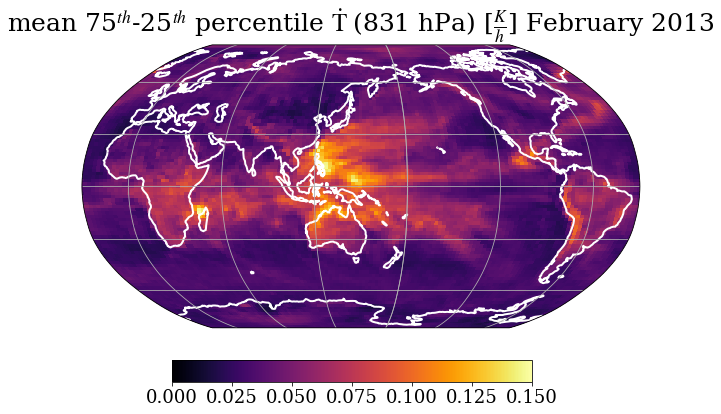

In [29]:
# inter quartile range dot T on 831 hPa refernce presssure over ocean

fig=plt.figure(1,(10,6))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=150))
pl=ax.pcolor(lon,lat,3600*np.mean(np.reshape((perc_75[:,22+26]-perc_25[:,22+26]),(int(time_step),96,144)),0), transform=ccrs.PlateCarree(),cmap='inferno',vmin=0,vmax=0.15)
ax.coastlines(color='white',linewidth=2)
ax.gridlines()
cbar_ax = fig.add_axes([0.25, 0.05, 0.50, 0.05])
fig.colorbar(pl,cax=cbar_ax,orientation='horizontal')
ax.set_title(r"mean 75$^{th}$-25$^{th}$ percentile $\mathrm{\dot{T}}~$(831 hPa) [$\frac{K}{h}$] February 2013",fontsize=25)


Text(0.5, 1.0, 'mean 75$^{th}$-25$^{th}$ percentile $\\mathrm{\\dot{T}~}$(469 hPa) [$\\frac{K}{h}$] February 2013')

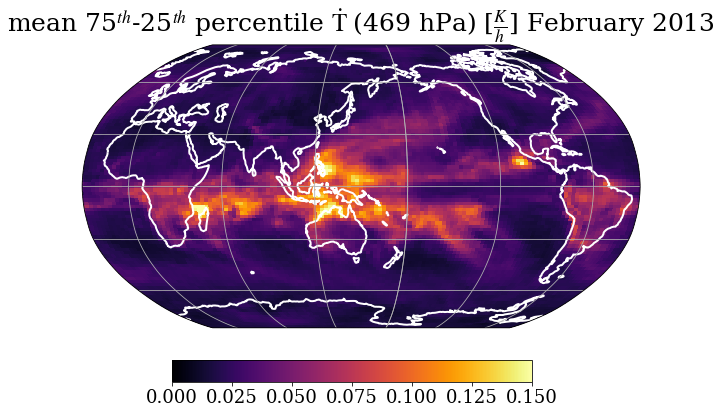

In [30]:
# inter quartile range dot T on 469 hPa refernce presssure over ocean


fig=plt.figure(1,(10,6))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=150))
pl=ax.pcolor(lon,lat,3600*np.mean(np.reshape((perc_75[:,18+26]-perc_25[:,18+26]),(int(time_step),96,144)),0), transform=ccrs.PlateCarree(),cmap='inferno',vmin=0,vmax=0.15)
ax.coastlines(color='white',linewidth=2)
ax.gridlines()
cbar_ax = fig.add_axes([0.25, 0.05, 0.50, 0.05])
fig.colorbar(pl,cax=cbar_ax,orientation='horizontal')
ax.set_title(r"mean 75$^{th}$-25$^{th}$ percentile $\mathrm{\dot{T}~}$(469 hPa) [$\frac{K}{h}$] February 2013",fontsize=25)


Text(0.5, 1.0, 'mean 75$^{th}$-25$^{th}$ percentile $\\mathrm{\\dot{q}~}$(831 hPa) [$\\frac{g}{kg \\times h}$] February 2013')

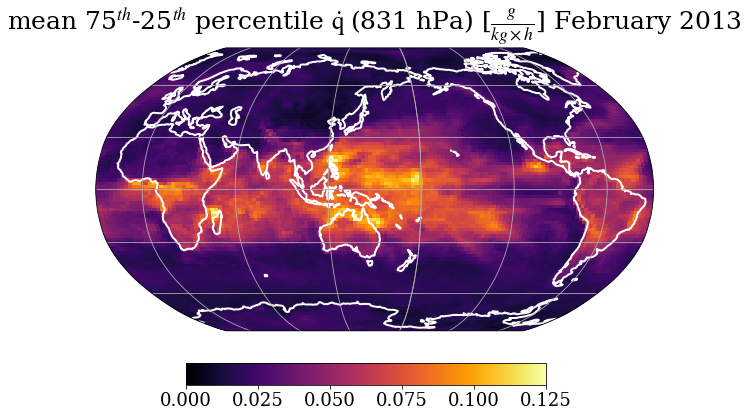

In [31]:
# inter quartile range dot q on 831 hPa refernce presssure over ocean


fig=plt.figure(1,(10,6))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=150))
pl=ax.pcolor(lon,lat,3600*1000*np.mean(np.reshape((perc_75[:,22]-perc_25[:,22]),(int(time_step),96,144)),0), transform=ccrs.PlateCarree(),cmap='inferno',vmin=0,vmax=0.125)
ax.coastlines(color='white',linewidth=2)
ax.gridlines()
cbar_ax = fig.add_axes([0.25, 0.05, 0.50, 0.05])
fig.colorbar(pl,cax=cbar_ax,orientation='horizontal')
ax.set_title(r"mean 75$^{th}$-25$^{th}$ percentile $\mathrm{\dot{q}~}$(831 hPa) [$\frac{g}{kg \times h}$] February 2013",fontsize=25)


Text(0.5, 1.0, 'mean 75$^{th}$-25$^{th}$ percentile $\\mathrm{\\dot{q}~}$(469 hPa) [$\\frac{g}{kg \\times h}$] February 2013')

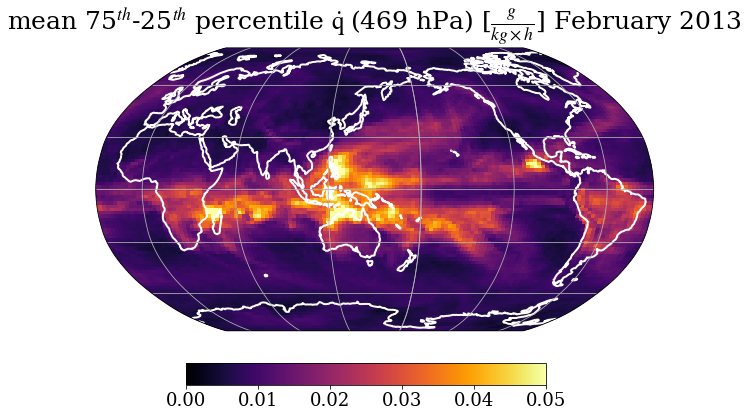

In [32]:
# inter quartile range dot q on 469 hPa refernce presssure over ocean


fig=plt.figure(1,(10,6))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=150))
pl=ax.pcolor(lon,lat,3600*1000*np.mean(np.reshape((perc_75[:,18]-perc_25[:,18]),(int(time_step),96,144)),0), transform=ccrs.PlateCarree(),cmap='inferno',vmin=0,vmax=0.05)
ax.coastlines(color='white',linewidth=2)
ax.gridlines()
cbar_ax = fig.add_axes([0.25, 0.05, 0.50, 0.05])
fig.colorbar(pl,cax=cbar_ax,orientation='horizontal')
ax.set_title(r"mean 75$^{th}$-25$^{th}$ percentile $\mathrm{\dot{q}~}$(469 hPa) [$\frac{g}{kg \times h}$] February 2013",fontsize=25)


Text(0.5, 1.0, 'mean 75$^{th}$-25$^{th}$ percentile $Snow_{CRM}$ [$\\frac{mm}{h}$] February 2013')

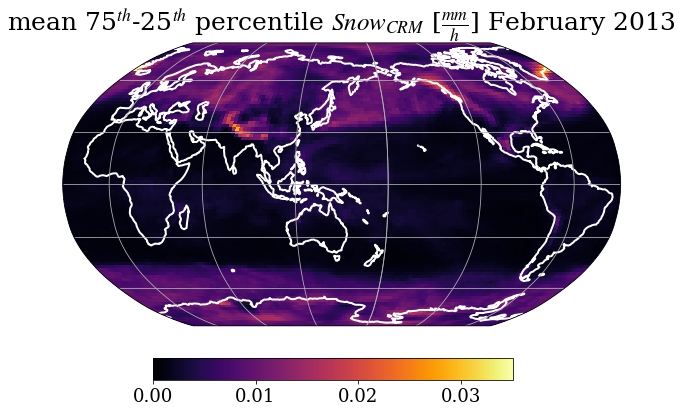

In [33]:
# inter quartile range snow 


fig=plt.figure(1,(10,6))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=150))
pl=ax.pcolor(lon,lat,3600*1000*np.mean(np.reshape((perc_75[:,104]-perc_25[:,104]),(int(time_step),96,144)),0), transform=ccrs.PlateCarree(),cmap='inferno',vmin=0,vmax=0.035)
ax.coastlines(color='white',linewidth=2)
ax.gridlines()
cbar_ax = fig.add_axes([0.25, 0.05, 0.50, 0.05])
fig.colorbar(pl,cax=cbar_ax,orientation='horizontal')
ax.set_title(r"mean 75$^{th}$-25$^{th}$ percentile $Snow_{CRM}$ [$\frac{mm}{h}$] February 2013",fontsize=25)



Text(0.5, 1.0, 'mean 75$^{th}$-25$^{th}$ percentile $Prec_{CRM}$ [$\\frac{mm}{h}$] February 2013')

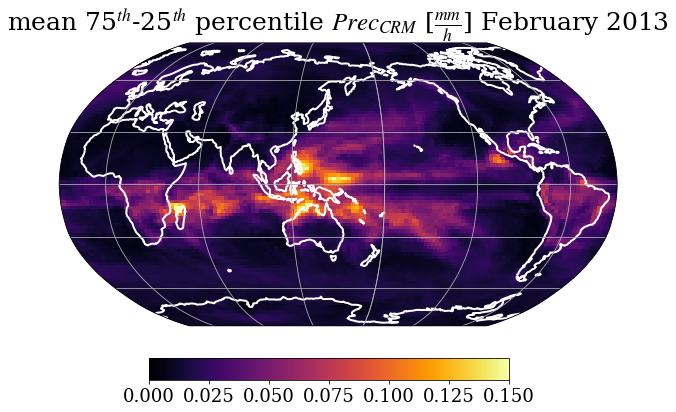

In [34]:
# inter quartile range precip 


fig=plt.figure(1,(10,6))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=150))
pl=ax.pcolor(lon,lat,3600*1000*np.mean(np.reshape((perc_75[:,105]-perc_25[:,105]),(int(time_step),96,144)),0), transform=ccrs.PlateCarree(),cmap='inferno',vmin=0,vmax=0.15)
ax.coastlines(color='white',linewidth=2)
ax.gridlines()
cbar_ax = fig.add_axes([0.25, 0.05, 0.50, 0.05])
fig.colorbar(pl,cax=cbar_ax,orientation='horizontal')
ax.set_title(r"mean 75$^{th}$-25$^{th}$ percentile $Prec_{CRM}$ [$\frac{mm}{h}$] February 2013",fontsize=25)



Text(0.5, 1.0, 'mean 75$^{th}$-25$^{th}$ percentile $Q_{lw \\ surf}$ [$\\frac{W}{m^2}$] February 2013')

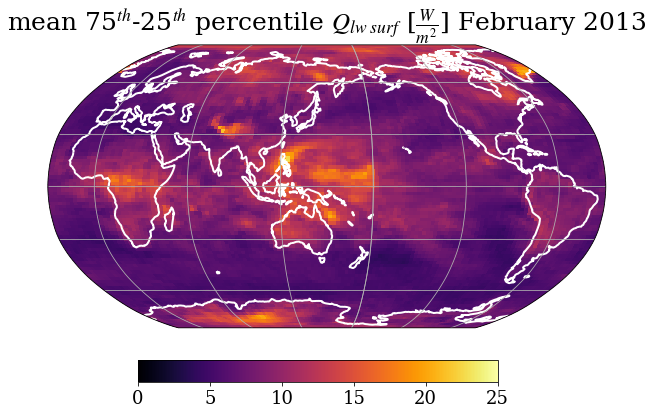

In [35]:
# inter quartile range longwave surface 


fig=plt.figure(1,(10,6))
ax=plt.axes(projection=ccrs.Robinson(central_longitude=150))
pl=ax.pcolor(lon,lat,np.mean(np.reshape((perc_75[:,106]-perc_25[:,106]),(int(time_step),96,144)),0), transform=ccrs.PlateCarree(),cmap='inferno',vmin=0,vmax=25)
ax.coastlines(color='white',linewidth=2)
ax.gridlines()
cbar_ax = fig.add_axes([0.25, 0.05, 0.50, 0.05])
fig.colorbar(pl,cax=cbar_ax,orientation='horizontal')
ax.set_title(r"mean 75$^{th}$-25$^{th}$ percentile $Q_{lw \ surf}$ [$\frac{W}{m^2}$] February 2013",fontsize=25)



Text(0.0, 1.0, 'd) $Prec_{CRM}$ [$\\frac{mm}{h}$]')

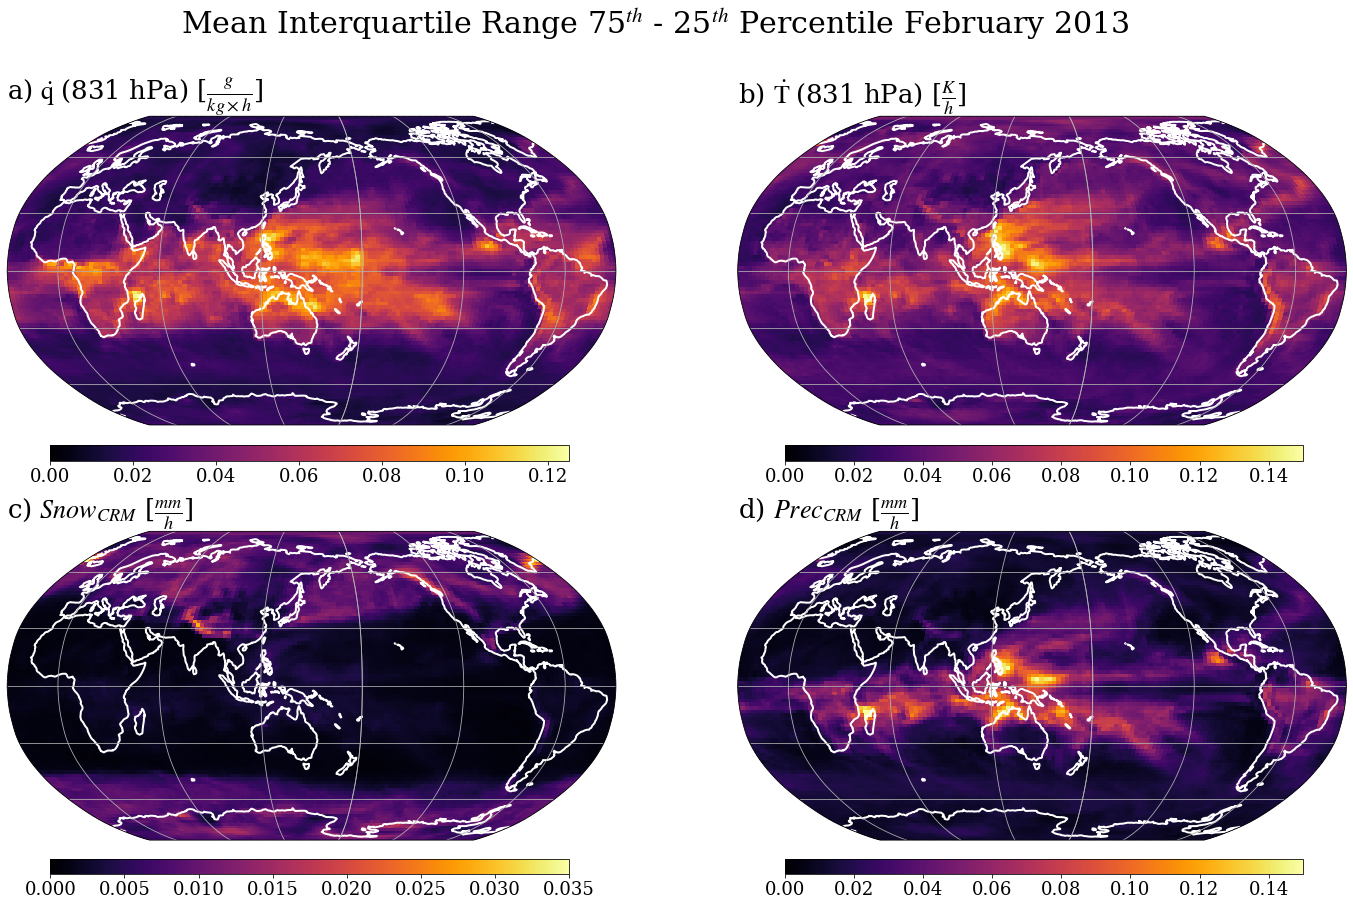

In [36]:
# combine plots for paper:

fig,ax=plt.subplots(2,2, figsize=(24,14), subplot_kw={'projection':ccrs.Robinson(central_longitude=150)})

plt.suptitle(r'Mean Interquartile Range 75$^{th}$ - 25$^{th}$ Percentile February 2013', fontsize=30, y=0.97)

pl=ax[0][0].pcolor(lon,lat,3600*1000*np.mean(np.reshape((perc_75[:,22]-perc_25[:,22]),(int(time_step),96,144)),0), transform=ccrs.PlateCarree(),cmap='inferno',vmin=0,vmax=0.125)
ax[0][0].coastlines(color='white',linewidth=2)
ax[0][0].gridlines()
cbar_ax=fig.add_axes([0.15, 0.52, 0.30, 0.015])
fig.colorbar(pl,cax=cbar_ax,orientation='horizontal')
ax[0][0].set_title(r"a) $\mathrm{\dot{q}~}$(831 hPa) [$\frac{g}{kg \times h}$]",fontsize=26, loc='left')



pl_2=ax[0][1].pcolor(lon,lat,3600*np.mean(np.reshape((perc_75[:,22+26]-perc_25[:,22+26]),(int(time_step),96,144)),0), transform=ccrs.PlateCarree(),cmap='inferno',vmin=0,vmax=0.15)
ax[0][1].coastlines(color='white',linewidth=2)
ax[0][1].gridlines()
cbar_ax_2 = fig.add_axes([0.575, 0.52, 0.30, 0.015])
fig.colorbar(pl_2,cax=cbar_ax_2,orientation='horizontal')
ax[0][1].set_title(r"b) $\mathrm{\dot{T}}~$(831 hPa) [$\frac{K}{h}$]",fontsize=26, loc='left')



pl_3=ax[1][0].pcolor(lon,lat,3600*1000*np.mean(np.reshape((perc_75[:,104]-perc_25[:,104]),(int(time_step),96,144)),0), transform=ccrs.PlateCarree(),cmap='inferno',vmin=0,vmax=0.035)
ax[1][0].coastlines(color='white',linewidth=2)
ax[1][0].gridlines()
cbar_ax=fig.add_axes([0.15, 0.11, 0.30, 0.015])
fig.colorbar(pl_3,cax=cbar_ax,orientation='horizontal')
ax[1][0].set_title(r"c) $Snow_{CRM}$ [$\frac{mm}{h}$]",fontsize=26, loc='left')


pl_4=ax[1][1].pcolor(lon,lat,3600*1000*np.mean(np.reshape((perc_75[:,105]-perc_25[:,105]),(int(time_step),96,144)),0), transform=ccrs.PlateCarree(),cmap='inferno',vmin=0,vmax=0.15)
ax[1][1].coastlines(color='white',linewidth=2)
ax[1][1].gridlines()
cbar_ax_4 = fig.add_axes([0.575, 0.11, 0.30, 0.015])
fig.colorbar(pl_4,cax=cbar_ax_4,orientation='horizontal')
ax[1][1].set_title(r"d) $Prec_{CRM}$ [$\frac{mm}{h}$]",fontsize=26, loc='left')





# Zonal averages of dot q and T

Text(0.5, 1.0, 'b) $\\mathrm{\\dot{T}}~$(p) [$\\frac{g}{kg \\times h}$]')

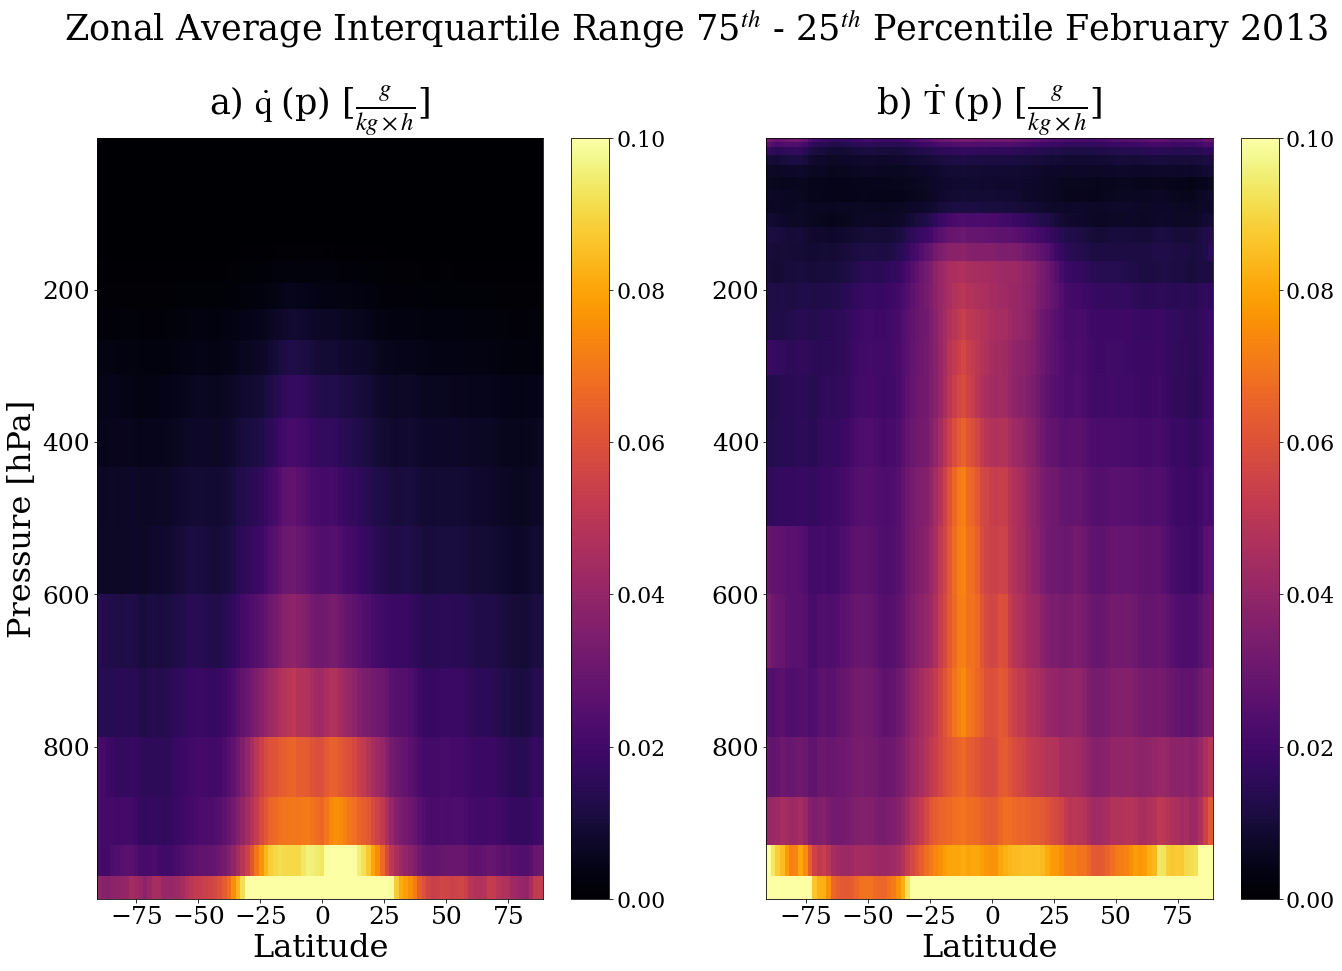

In [37]:
# plot zonala averages of interquartile range for dot q and dot T 
plt.figure(1,(22,14))


plt.suptitle(' Zonal Average Interquartile Range 75$^{th}$ - 25$^{th}$ Percentile February 2013',fontsize=35, y=1.01)

plt.subplot(1,2,1)
plt.pcolor(lat,P[0:26]/100,3600*1000*np.mean(np.mean(np.reshape((perc_75[:,0:26]-perc_25[:,0:26]),(int(time_step),96,144,26)),0),1).T,cmap='inferno',vmin=0,vmax=0.10)
sr=plt.gca()
sr.invert_yaxis()
cb_1=plt.colorbar()
cb_1.ax.tick_params(labelsize=22)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)

plt.ylabel('Pressure [hPa]',fontsize=32)
plt.xlabel('Latitude',fontsize=32)
plt.title(r"a) $\mathrm{\dot{q}}~$(p) [$\frac{g}{kg \times h}$]",fontsize=35)


plt.subplot(1,2,2)
plt.pcolor(lat,P[0:26]/100,3600*np.mean(np.mean(np.reshape((perc_75[:,26:52]-perc_25[:,26:52]),(int(time_step),96,144,26)),0),1).T,cmap='inferno',vmin=0,vmax=0.10)
sr=plt.gca()
sr.invert_yaxis()
cb_2=plt.colorbar()
cb_2.ax.tick_params(labelsize=22)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.xlabel('Latitude',fontsize=32)
plt.title(r"b) $\mathrm{\dot{T}}~$(p) [$\frac{g}{kg \times h}$]",fontsize=35)



In [38]:
#load basemap for ocean vs. land split
from mpl_toolkits.basemap import maskoceans
from mpl_toolkits.basemap import Basemap

map = Basemap(projection='sinu', 
              lat_0=0, lon_0=0)

# shift data 
Lons,Lats = np.meshgrid(lon,lat)
lons_2, data_shift = map.shiftdata(Lons, datain = np.reshape(np.ones((96*144,1)),
                                                             (lat.size,lon.size)) 
                                                             , lon_0=0)

In [39]:
# mask ocean area
MaskedArray_2 = maskoceans(lons_2,Lats,np.reshape(np.ones((96*144,1)),
                                                             (lat.size,lon.size)),resolution='f',grid=1.25,inlands=False)


In [40]:
# split between ocean and land grid cells 
ocean=np.where(np.reshape(MaskedArray_2.mask,(lat.size*lon.size))==True)[0]
land=np.where(np.reshape(MaskedArray_2.mask,(lat.size*lon.size))==False)[0]

In [41]:

def flag_ocean_land(input_array,ocean_land):
    """
    flag out ocean or land grid cells 
    for multiple time steps of hybrid simulations
    
    """
    input_array_copy=np.nan*np.zeros((int(lat.size*lon.size),input_array[1,:].size))
    input_array_resh=np.reshape(input_array,(int(lat.size*lon.size),input_array[1,:].size))
    input_array_copy[ocean_land.astype('int'),:]=input_array_resh[ocean_land.astype('int'),:]
    
    input_array_copy_resh=np.reshape(input_array_copy,(input_array.shape))
    
    return input_array_copy_resh

In [42]:
# compute interquartile range over ocean and land for dot q 
q_mean_ocean=flag_ocean_land(np.mean(np.reshape((perc_75[:,0:26]-perc_25[:,0:26]),(int(time_step),int(96*144),26)),0),ocean)
q_mean_land=flag_ocean_land(np.mean(np.reshape((perc_75[:,0:26]-perc_25[:,0:26]),(int(time_step),int(96*144),26)),0),land)


In [43]:
# compute interquartile range over ocean and land for dot T 

T_mean_ocean=flag_ocean_land(np.mean(np.reshape((perc_75[:,26:52]-perc_25[:,26:52]),(int(time_step),int(96*144),26)),0),ocean)
T_mean_land=flag_ocean_land(np.mean(np.reshape((perc_75[:,26:52]-perc_25[:,26:52]),(int(time_step),int(96*144),26)),0),land)


Text(0.5, 1.0, '$\\mathrm{\\dot{T}}~$(p) [$\\frac{g}{kg \\times h}$]')

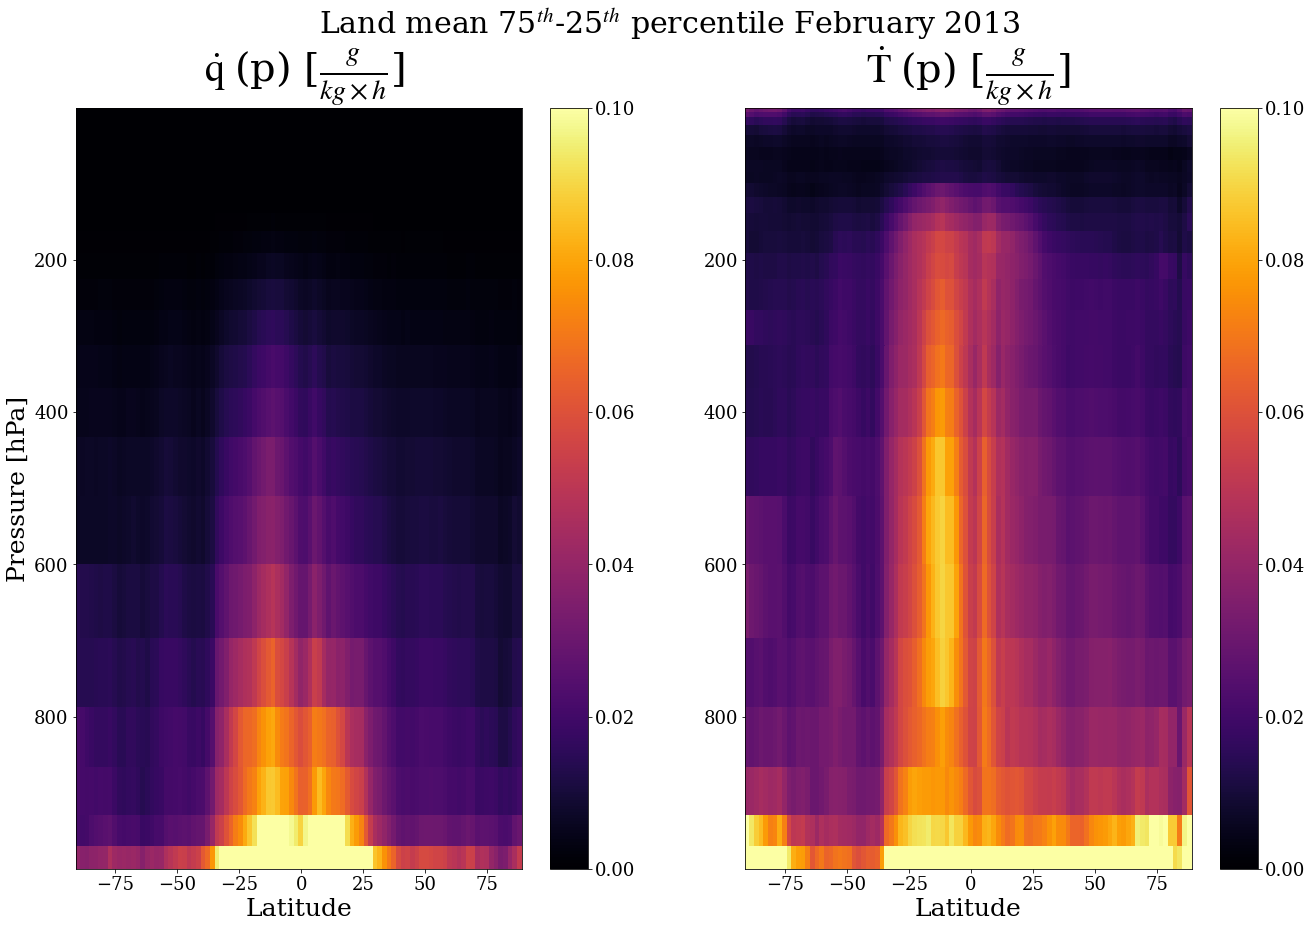

In [44]:
plt.figure(1,(22,14))
plt.suptitle('Land mean 75$^{th}$-25$^{th}$ percentile February 2013',fontsize=30)
plt.subplot(1,2,1)
plt.pcolor(lat,P[0:26]/100,3600*1000*np.nanmean(np.reshape(q_mean_land,(96,144,26)),1).T,cmap='inferno',vmin=0,vmax=0.10)
sr=plt.gca()
sr.invert_yaxis()
plt.colorbar()
plt.ylabel('Pressure [hPa]',fontsize=25)
plt.xlabel('Latitude',fontsize=25)
plt.title(r" $\mathrm{\dot{q}}~$(p) [$\frac{g}{kg \times h}$]",fontsize=40)


plt.subplot(1,2,2)
plt.pcolor(lat,P[0:26]/100,3600*np.nanmean(np.reshape(T_mean_land,(96,144,26)),1).T,cmap='inferno',vmin=0,vmax=0.10)
sr=plt.gca()
sr.invert_yaxis()
plt.colorbar()
plt.xlabel('Latitude',fontsize=25)
plt.title(r"$\mathrm{\dot{T}}~$(p) [$\frac{g}{kg \times h}$]",fontsize=40)



/tmp/ipykernel_3994597/1347140771.py:4: RuntimeWarning: Mean of empty slice
  plt.pcolor(lat,P[0:26]/100,3600*1000*np.nanmean(np.reshape(q_mean_ocean,(96,144,26)),1).T,cmap='inferno',vmin=0,vmax=0.10)
/tmp/ipykernel_3994597/1347140771.py:14: RuntimeWarning: Mean of empty slice
  plt.pcolor(lat,P[0:26]/100,3600*np.nanmean(np.reshape(T_mean_ocean,(96,144,26)),1).T,cmap='inferno',vmin=0,vmax=0.10)


Text(0.5, 1.0, '$\\mathrm{\\dot{T}}~$(p) [$\\frac{g}{kg \\times h}$]')

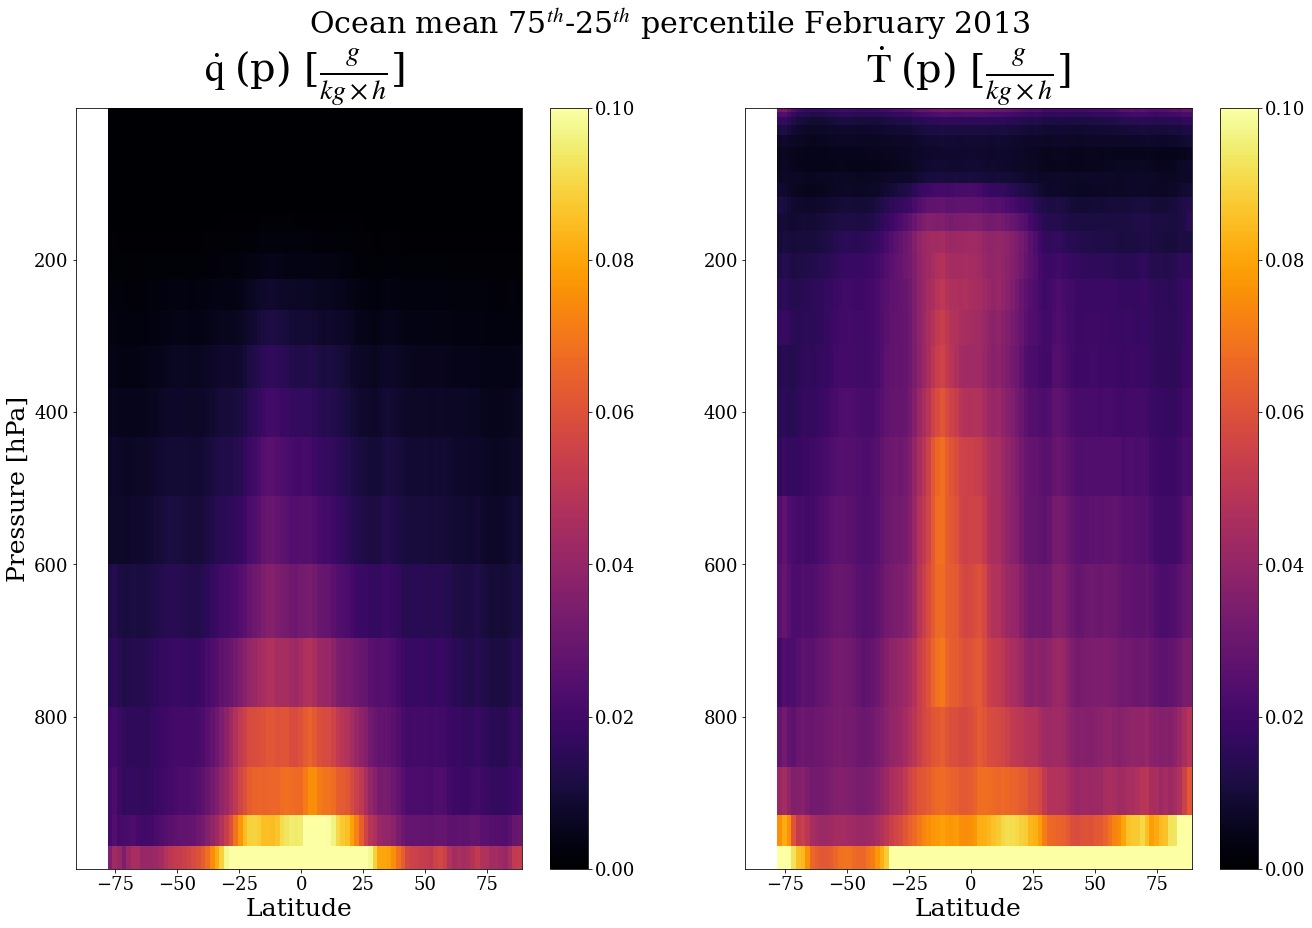

In [45]:
plt.figure(1,(22,14))
plt.suptitle('Ocean mean 75$^{th}$-25$^{th}$ percentile February 2013',fontsize=30)
plt.subplot(1,2,1)
plt.pcolor(lat,P[0:26]/100,3600*1000*np.nanmean(np.reshape(q_mean_ocean,(96,144,26)),1).T,cmap='inferno',vmin=0,vmax=0.10)
sr=plt.gca()
sr.invert_yaxis()
plt.colorbar()
plt.ylabel('Pressure [hPa]',fontsize=25)
plt.xlabel('Latitude',fontsize=25)
plt.title(r" $\mathrm{\dot{q}}~$(p) [$\frac{g}{kg \times h}$]",fontsize=40)


plt.subplot(1,2,2)
plt.pcolor(lat,P[0:26]/100,3600*np.nanmean(np.reshape(T_mean_ocean,(96,144,26)),1).T,cmap='inferno',vmin=0,vmax=0.10)
sr=plt.gca()
sr.invert_yaxis()
plt.colorbar()
plt.xlabel('Latitude',fontsize=25)
plt.title(r"$\mathrm{\dot{T}}~$(p) [$\frac{g}{kg \times h}$]",fontsize=40)

